In this first part, we install import all the packages used

In [1]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix



#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns



In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

# Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

# Ensure that TensorFlow is using GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Check TensorFlow version for reference
print("TensorFlow Version:", tf.__version__)

No GPU found. Using CPU.
TensorFlow Version: 2.14.0


Next, we import some stock data

In [3]:
tickers = ["AAPL", "META"]
start_date = "2013-10-01"
end_date = "2023-10-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [4]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 2)
    data['Lagged_Return_2'] = lagged_return(data, 3)
    data['Lagged_Return_3'] = lagged_return(data, 4)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs. 

In [5]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # Store the index right after splitting
    X_test_index = X_test.index

    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.

Now, we normalize the data to pe ready for Neural network

In [6]:
from sklearn.preprocessing import StandardScaler

# Iterate over each stock's data
for ticker, data_splits in all_stock_data.items():
    scaler = StandardScaler()

    # Scale the training data and convert it back to DataFrame to keep the index
    X_train_scaled = scaler.fit_transform(data_splits['X_train'])
    data_splits['X_train'] = pd.DataFrame(X_train_scaled, index=data_splits['X_train'].index, columns=data_splits['X_train'].columns)

    # Do the same for the validation and test data
    X_val_scaled = scaler.transform(data_splits['X_val'])
    data_splits['X_val'] = pd.DataFrame(X_val_scaled, index=data_splits['X_val'].index, columns=data_splits['X_val'].columns)

    X_test_scaled = scaler.transform(data_splits['X_test'])
    data_splits['X_test'] = pd.DataFrame(X_test_scaled, index=data_splits['X_test'].index, columns=data_splits['X_test'].columns)

    # Update the dictionary with scaled data
    all_stock_data[ticker] = data_splits


Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Import necessary libraries from Keras Tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report

# Define the model with hyperparameters
# Define the model with hyperparameters, now including the number of layers
def build_model(hp):
    model = Sequential()

    # Choose a number of dense layers between 2 and 5
    for i in range(hp.Int('num_layers', 2, 5)):
        # Add dense layers with a number of units and a dropout layer following each
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu', input_shape=(combined_X_train.shape[1],) if i==0 else []))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer with a single unit for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a choice of learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Combine all the training and validation data
combined_X_train = np.vstack([all_stock_data[ticker]['X_train'] for ticker in all_stock_data])
combined_y_train = np.hstack([all_stock_data[ticker]['y_train'] for ticker in all_stock_data])
combined_X_val = np.vstack([all_stock_data[ticker]['X_val'] for ticker in all_stock_data])
combined_y_val = np.hstack([all_stock_data[ticker]['y_val'] for ticker in all_stock_data])

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=4,
    directory='tuning_dir',
    project_name='combined_stock_data'
)

# Search for the best hyperparameters
tuner.search(combined_X_train, combined_y_train, epochs=150, validation_data=(combined_X_val, combined_y_val))  

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
model = tuner.hypermodel.build(best_hps)
model.fit(combined_X_train, combined_y_train, epochs=150, batch_size=32, verbose=1, validation_data=(combined_X_val, combined_y_val))

# Validate the model
_, accuracy = model.evaluate(combined_X_val, combined_y_val, verbose=0)

# Predict the validation data
y_val_pred = (model.predict(combined_X_val) > 0.5).astype(int).flatten()

# Performance report
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(combined_y_val, y_val_pred))

# Save the model if needed
model.save('ModelSaved')


Using TensorFlow backend
Reloading Tuner from tuning_dir\combined_stock_data\tuner0.json
Epoch 1/150
110/110 [==============================] - 2s 7ms/step - loss: 0.5923 - accuracy: 0.7017 - val_loss: 0.5508 - val_accuracy: 0.7019
Epoch 2/150
110/110 [==============================] - 0s 3ms/step - loss: 0.5431 - accuracy: 0.7427 - val_loss: 0.5608 - val_accuracy: 0.7353
Epoch 3/150
110/110 [==============================] - 1s 5ms/step - loss: 0.5389 - accuracy: 0.7496 - val_loss: 0.6112 - val_accuracy: 0.6725
Epoch 4/150
110/110 [==============================] - 0s 4ms/step - loss: 0.5324 - accuracy: 0.7504 - val_loss: 0.5483 - val_accuracy: 0.7299
Epoch 5/150
110/110 [==============================] - 1s 5ms/step - loss: 0.5285 - accuracy: 0.7510 - val_loss: 0.5564 - val_accuracy: 0.7246
Epoch 6/150
110/110 [==============================] - 1s 5ms/step - loss: 0.5257 - accuracy: 0.7556 - val_loss: 0.5386 - val_accuracy: 0.7326
Epoch 7/150
110/110 [==============================] 

INFO:tensorflow:Assets written to: ModelSaved\assets


After we have trained the model on the validation set, we will now test on an out of sample test. In other words, we test on new data.

In [8]:
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store test set performances
test_performances = {}

# List to store all accuracy scores
all_accuracies = []

# Use the single trained model for predictions on each stock's test data
for ticker in all_stock_data:
    # Get the test data for the current stock
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']

    # Predict using the single trained model
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to class labels
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store the performance on the test set
    test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test, y_test_pred, output_dict=True)
    }

    # Add the accuracy to the list
    all_accuracies.append(test_accuracy)

    # Print out the test performance for the current stock
    print(f"Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print("-------------------------------------------------")

# Calculate and print the average accuracy
average_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f"Average Test Accuracy across all stocks: {average_accuracy:.4f}")


12/12 [==============================] - 0s 3ms/step
Test Performance for AAPL:
Test Accuracy: 0.5520
              precision    recall  f1-score   support

           0       0.59      0.29      0.39       184
           1       0.54      0.81      0.65       191

    accuracy                           0.55       375
   macro avg       0.56      0.55      0.52       375
weighted avg       0.56      0.55      0.52       375

-------------------------------------------------
12/12 [==============================] - 0s 2ms/step
Test Performance for META:
Test Accuracy: 0.6507
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       185
           1       0.67      0.60      0.64       190

    accuracy                           0.65       375
   macro avg       0.65      0.65      0.65       375
weighted avg       0.65      0.65      0.65       375

-------------------------------------------------
Average Test Accuracy across all stocks: 0

Now we start backtesting the models. We make a list that includes the predicted return and the actual return.

In [9]:
from keras.models import load_model

# Load the previously saved model
nn_model = load_model('ModelSaved')

# Initialize the list to store results
stock_results = []

# Loop through each ticker to extract predictions and actual returns
for ticker in all_stock_data:
    # Retrieve the test data for the current ticker
    X_test_ticker = all_stock_data[ticker]['X_test']
    
    # Predict using the neural network model
    nn_predictions = nn_model.predict(X_test_ticker)
    
    # Process neural network predictions if necessary
    nn_predictions_processed = (nn_predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary class labels
    
    # Calculate the actual daily return for the stock
    # Assume 'Close' prices are in the stock_data[ticker] DataFrame
    daily_returns = stock_data[ticker]['Close'].pct_change().shift(-1).loc[X_test_ticker.index].dropna()
    
    # Append the results to the stock_results list
    stock_results.append({
        'Ticker': ticker,
        'NN Predictions': nn_predictions_processed,
        'Actual Daily Returns': daily_returns.values
    })

# Now, the stock_results list contains the predictions from the neural network model and the actual daily returns for each stock.


12/12 [==============================] - 0s 4ms/step


In [10]:
for ticker, stock_data in all_stock_data.items():
    
    # Create an empty DataFrame for each stock
    df = pd.DataFrame(columns=['Date', 'daily return', 'Neural Network'])

    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']

    # Assuming test_dates are the dates aligned with X_test
    test_dates = data.index[-len(X_test):]

    # Retrieve the 'Close' prices for the test dates
    Returndata = data.loc[test_dates, 'Close']

    # Calculate the daily returns for the 'Close' prices
    daily_returns = Returndata.pct_change()

    # Predict using the single trained neural network model
    y_test_pred_nn = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Create a DataFrame for the current stock
    ResultsReturnAndPrediction = pd.DataFrame({
        'Date': test_dates,
        'daily return': daily_returns.tolist(),
        'Neural Network': y_test_pred_nn.tolist()
    })

    # Append the stock DataFrame to the main DataFrame
    df = pd.concat([df, ResultsReturnAndPrediction], ignore_index=True)

    # Drop rows with NaN values in any column
    df = df.dropna()

    # Print the resulting DataFrame for each stock
    print(f"Data for {ticker}:")
    print(df)


12/12 [==============================] - 0s 2ms/step
Data for AAPL:
          Date  daily return Neural Network
1   2022-04-05     -0.008765              1
2   2022-04-06     -0.036836              1
3   2022-04-07     -0.001567              1
4   2022-04-08     -0.002781              1
5   2022-04-11     -0.026402              1
..         ...           ...            ...
370 2023-09-25      0.005851              1
371 2023-09-26     -0.006216              1
372 2023-09-27     -0.004081              1
373 2023-09-28      0.020891              1
374 2023-09-29     -0.012337              1

[374 rows x 3 columns]
12/12 [==============================] - 0s 3ms/step
Data for META:
          Date  daily return Neural Network
1   2022-04-05     -0.008765              0
2   2022-04-06     -0.036836              1
3   2022-04-07     -0.001567              1
4   2022-04-08     -0.002781              0
5   2022-04-11     -0.026402              0
..         ...           ...            ...
370 

We perform the backtest and plot the results

12/12 [==============================] - 0s 1ms/step


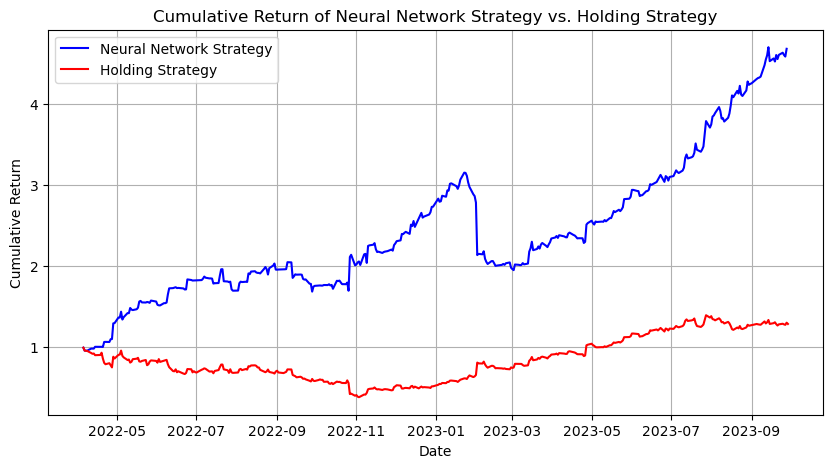

In [45]:
# DataFrames to store cumulative returns time series for all stocks
df_daily_returns_all_stocks = pd.DataFrame()
df_strategy_returns_all_stocks = pd.DataFrame()

for ticker, stock_data in all_stock_data.items():
    
    # Extract the test data and the returns data
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']

    # Assuming test_dates are the dates aligned with X_test
    test_dates = data.index[-len(X_test):]

    # Retrieve the 'Close' prices for the test dates
    Returndata = data.loc[test_dates, 'Close']

    # Calculate the daily returns for the 'Close' prices
    daily_returns = Returndata.pct_change()
    df_daily_returns_all_stocks[ticker] = daily_returns  # Store daily returns for each stock

    # Predict using the single trained neural network model
    y_test_pred_nn = (model.predict(X_test) > 0.5).astype(int).flatten()
    
    # Check if all predictions are the same
    if len(set(y_test_pred_nn)) == 1:
        print(f"All predictions for {ticker} are the same.")
        continue

    # Convert predictions to a Series with the test dates as its index
    y_test_pred_nn_series = pd.Series(y_test_pred_nn, index=test_dates)

    # Shift the predictions by one day forward
    y_test_pred_nn_series_shifted = y_test_pred_nn_series.shift(-1)

    # Calculate strategy daily returns based on the shifted predictions
    strategy_returns_nn = daily_returns * (2 * y_test_pred_nn_series_shifted - 1)

    # Store strategy daily returns for each stock
    df_strategy_returns_all_stocks[ticker] = strategy_returns_nn

    # Calculate cumulative returns time series for the neural network strategy
    df_strategy_returns_all_stocks[f"{ticker}_NN_Strategy"] = (1 + strategy_returns_nn).cumprod()

# Remove NaN values that are a result of the shift in predictions
df_strategy_returns_all_stocks = df_strategy_returns_all_stocks.dropna()

# Calculate cumulative returns for holding strategy
cumulative_returns_holding = (1 + df_daily_returns_all_stocks.mean(axis=1)).cumprod()

# Calculate cumulative returns for the neural network strategy
cumulative_returns_nn_strategy = df_strategy_returns_all_stocks.filter(like="_NN_Strategy").mean(axis=1)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_nn_strategy.index, cumulative_returns_nn_strategy.values, label='Neural Network Strategy', color='blue')
plt.plot(cumulative_returns_holding.index, cumulative_returns_holding.values, label='Holding Strategy', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Neural Network Strategy vs. Holding Strategy')
plt.legend()
plt.grid(True)
plt.show()


Now we calculate the sharpe ratios from the strategies

In [47]:
# Calculate daily returns for the neural network strategy
daily_returns_nn_strategy = df_strategy_returns_all_stocks.filter(like="_NN_Strategy").pct_change().mean(axis=1).fillna(0)

# Calculate daily returns for the holding strategy
daily_returns_holding = df_daily_returns_all_stocks.mean(axis=1).fillna(0)

# Calculate the mean daily return for each strategy
mean_return_nn_strategy = daily_returns_nn_strategy.mean()
mean_return_holding = daily_returns_holding.mean()

# Calculate the standard deviation of daily returns for each strategy
std_dev_nn_strategy = daily_returns_nn_strategy.std()
std_dev_holding = daily_returns_holding.std()

# Compute the Sharpe ratio for each strategy (assuming risk-free rate is 0)
sharpe_ratio_nn_strategy = mean_return_nn_strategy / std_dev_nn_strategy
sharpe_ratio_holding = mean_return_holding / std_dev_holding

print(f"Sharpe Ratio (Neural Network Strategy): {sharpe_ratio_nn_strategy:.4f}")
print(f"Sharpe Ratio (Holding Strategy): {sharpe_ratio_holding:.4f}")


Sharpe Ratio (Neural Network Strategy): 0.1137
Sharpe Ratio (Holding Strategy): 0.0366


In [48]:
import scipy.stats as stats

# Assuming df_strategy_returns_all_stocks has the daily returns for the neural network strategy
# before the cumulative calculation, and they are labeled with a unique identifier.
# Let's say they are labeled as 'NN_Daily_Returns'.

# Extract the daily returns for the neural network strategy before the cumulative calculation
nn_daily_returns = df_strategy_returns_all_stocks.filter(like="Strategy_retruns_nn").mean(axis=1).dropna()

# Extract the daily returns for the holding strategy
hold_daily_returns = df_daily_returns_all_stocks.mean(axis=1).dropna()

# Align both series to the same index
common_index = nn_daily_returns.index.intersection(hold_daily_returns.index)
nn_returns_aligned = nn_daily_returns.loc[common_index]
hold_returns_aligned = hold_daily_returns.loc[common_index]

# Ensure there is variation in the data and that neither series is constant
if nn_returns_aligned.std() == 0 or hold_returns_aligned.std() == 0:
    raise ValueError("One of the series is constant; a t-test is not appropriate.")

# Now we can perform the paired t-test
t_stat, p_value = stats.ttest_rel(nn_returns_aligned, hold_returns_aligned)

# Output the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the p-value
if p_value < 0.05:
    print("The neural network strategy performs significantly better than the hold strategy (reject H0)")
else:
    print("There is no significant difference between the neural network and hold strategy (fail to reject H0)")


T-statistic: nan, P-value: nan
There is no significant difference between the neural network and hold strategy (fail to reject H0)


In the plot above we have the most important features of the simple nontuned model.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize a cumulative confusion matrix with zeros
cumulative_cm = np.zeros((2, 2))

# Loop through each ticker and its corresponding data in all_stock_data
for ticker, stock_data in all_stock_data.items():
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    
    # Get predictions on the test set
    y_test_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()  # Threshold the predictions to get class labels
    
    # Add the confusion matrix for the current stock to the cumulative matrix
    cumulative_cm += confusion_matrix(y_test, y_test_pred)

# Calculate the average confusion matrix
average_cm = cumulative_cm / len(all_stock_data)

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Average Confusion Matrix on Test Data (Neural Network Model)")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Loop through each ticker and its corresponding data in all_stock_data
for ticker, stock_data in all_stock_data.items():
    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    
    # Predict probabilities using the neural network model
    y_prob = nn_model.predict(X_test)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{ticker} (AUC = {roc_auc:.2f})')

# Add the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Stocks')
plt.legend(loc="lower right")

# Display the plot
plt.show()


Now we want to make a plot that ensembles all the roc plots

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model.predict(combined_X_val) returns the predicted probabilities
y_pred_probs = model.predict(combined_X_val).ravel()

# Compute ROC curve and ROC area for the actual validation data
fpr, tpr, thresholds = roc_curve(combined_y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"The AUC score is: {roc_auc:.2f}")


In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

class AUCROC(Callback):
    def __init__(self, validation_data):
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]
        self.auc_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_val = self.model.predict(self.X_val)
        auc_score = roc_auc_score(self.y_val, y_pred_val)
        self.auc_scores.append(auc_score)
        print(f'Epoch {epoch+1}: AUC = {auc_score:.4f}')

# We need to instantiate the callback with your validation data
auc_roc_callback = AUCROC(validation_data=(combined_X_val, combined_y_val))

# Then we pass this callback to the fit method
model.fit(combined_X_train, combined_y_train, epochs=150, batch_size=32, verbose=1,
          validation_data=(combined_X_val, combined_y_val), callbacks=[auc_roc_callback])


In [ ]:
def plot_auc_vs_epochs(auc_roc_callback):
    epochs = range(1, len(auc_roc_callback.auc_scores) + 1)
    auc_scores = auc_roc_callback.auc_scores
    
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, auc_scores, '-o', label='Validation AUC')
    plt.title('Validation AUC vs. Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Validation AUC')
    plt.legend()
    plt.show()

# Example usage after the model has been trained:
plot_auc_vs_epochs(auc_roc_callback)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training history of a Keras model.

    :param history: The history object returned by the fit method of a Keras model.
    """
    plt.figure(figsize=(14, 5))

    # Summarize history for accuracy, if it exists
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Example of using this function:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
plot_training_history(history)


We look deeper into the training process of the model. Below we test if the model gets worse over time...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

# Define the window size for the rolling evaluation
window_size = 25  # Or any other size you deem appropriate

# Collect accuracies for all stocks
all_accuracies = []

# You'll need to replace 'model' with your actual trained model variable name
for ticker, data_splits in all_stock_data.items():
    X_test = data_splits['X_test']
    y_test = data_splits['y_test']
    X_test_index = X_test.index

    test_data_with_date = X_test.copy()
    test_data_with_date['label'] = y_test
    test_data_with_date['date'] = X_test_index

    accuracies = []

    for start in range(0, len(test_data_with_date) - window_size + 1):
        # Define the end of the window
        end = start + window_size

        # Slice the window of data
        window_data = test_data_with_date.iloc[start:end]
        X_window = window_data.drop(['date', 'label'], axis=1)
        y_window = window_data['label']

        # Make predictions for the current window
        y_pred_window = model.predict(X_window).round()  # Replace 'model' with your model variable

        # Calculate accuracy for the current window
        accuracy = accuracy_score(y_window, y_pred_window)
        accuracies.append(accuracy)

    all_accuracies.append(accuracies)

# Average the accuracies across all stocks for each time point
average_accuracies = np.mean(all_accuracies, axis=0)

# Prepare data for linear regression
dates = np.array(range(len(average_accuracies))).reshape(-1, 1)  # Simple integer index for dates
accuracies = np.array(average_accuracies).reshape(-1, 1)

# Linear regression
reg = LinearRegression().fit(dates, accuracies)
reg_line = reg.predict(dates)

# Plotting the average accuracy with a linear regression trend line
plt.figure(figsize=(14, 7))
plt.scatter(dates, accuracies, color='blue', label='Average Accuracy')
plt.plot(dates, reg_line, color='red', linewidth=2, label='Trend Line')
plt.xlabel('Time Point')
plt.ylabel('Average Accuracy')
plt.title('Average Model Accuracy Over Time with Linear Trend')
plt.legend()
plt.show()


The next couple of boxes are just for practice. May not be used.

In [ ]:
from keras.callbacks import TensorBoard
import time

# Unique name for the TensorBoard log files
log_dir = f"logs/fit/{time.strftime('%Y-%m-%d_%H-%M-%S')}"

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    combined_X_train,
    combined_y_train,
    epochs=150,
    batch_size=32,
    verbose=1,
    validation_data=(combined_X_val, combined_y_val),
    callbacks=[tensorboard_callback, auc_roc_callback]  # add the TensorBoard callback here
)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit
